# Tutorial 3: Inverse Design of a Power Splitter for Silicon Photonics

<p style="text-align: center;">
    <b>Alec Hammond</b>
    <br/>
    July 27, 2022
</p>

## Library import

In [77]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from matplotlib import pyplot as plt

1.25.0-beta


## Basic environment setup

In [78]:
seed = 240
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

waveguide_width = 0.5 # (μm)
design_region_width = 2.5 # (μm)
design_region_height = 2.5 # (μm)
arm_separation = 1.0 # (μm) distance between arms center to center
waveguide_length = 0.5 # (μm)
pml_size = 1.0 # (μm)
resolution = 20 # (pixels/μm)

## Design variable setup

In [79]:
minimum_length = 0.09 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)
eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(4*resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)

Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si)
design_region = mpa.DesignRegion(design_variables,
    volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height)))

## Simulation Setup

<AxesSubplot:xlabel='X', ylabel='Y'>

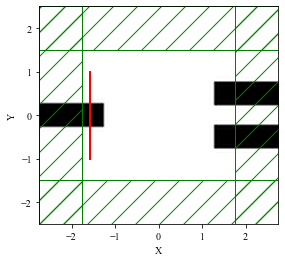

In [80]:
Sx = 2*pml_size + 2*waveguide_length + design_region_width # cell size in X
Sy = 2*pml_size + design_region_height + 0.5 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)
sim.plot2D()

## Design parameter mapping

In [92]:
def mapping(x,eta,beta):
    
    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    
    # filter
    filtered_field = mpa.conic_filter(x,
        filter_radius,design_region_width,design_region_height,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    # interpolate to actual materials
    return projected_field.flatten()



<AxesSubplot:xlabel='X', ylabel='Y'>

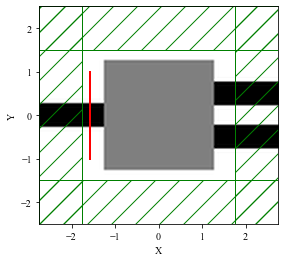

In [82]:
design_region.update_design_parameters(mapping(0.5*np.ones((Nx,Ny)),0.5,2))
sim.plot2D()

<AxesSubplot:xlabel='X', ylabel='Y'>

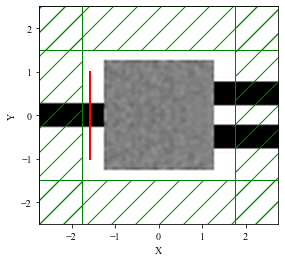

In [83]:
design_region.update_design_parameters(mapping(np.random.rand(Nx,Ny),0.5,2))
sim.plot2D()

<AxesSubplot:xlabel='X', ylabel='Y'>

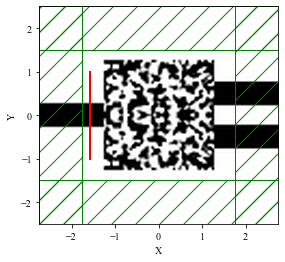

In [84]:
design_region.update_design_parameters(mapping(np.random.rand(Nx,Ny),0.5,256))
sim.plot2D()

## Optimization problem setup

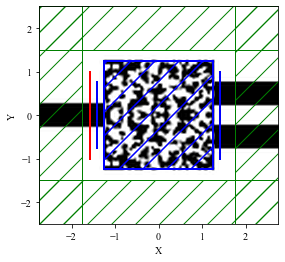

In [85]:
import autograd.numpy as npa

mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(x=-Sx/2 + pml_size + 2*waveguide_length/3),
            size=mp.Vector3(y=1.5)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,arm_separation/2,0),
            size=mp.Vector3(y=arm_separation)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3,-arm_separation/2,0),
            size=mp.Vector3(y=arm_separation)),mode)
ob_list = [TE0,TE_top,TE_bottom]

def J(source,top,bottom):
    power = npa.abs(top/source) ** 2 + npa.abs(bottom/source) ** 2
    return npa.mean(power)

opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies
)
opt.plot2D(True)

## Gradient computation

In [86]:
x0 = 0.5*np.ones((Nx,Ny))
f0, g0 = opt([mapping(x0,0.5,2)])

Starting forward run...
Starting adjoint run...
Calculating gradient...


(40000, 5)


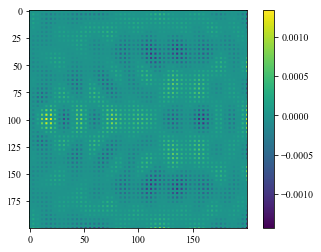

In [87]:
plt.figure()
print(g0.shape)
plt.imshow(np.rot90(g0[:,0].reshape(Nx,Ny)))
plt.colorbar()

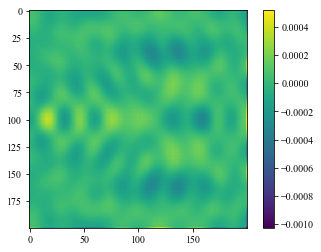

In [88]:
from autograd import tensor_jacobian_product
backprop_gradient = tensor_jacobian_product(mapping,0)(x0,0.5,2,g0[:,0])
plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
plt.colorbar()

# Optimizer setup

In [89]:
import nlopt
evaluation_history = []
cur_iter = [0]
def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0]+1))
    
    f0, dJ_du = opt([mapping(v,eta_i,cur_beta)])
    
    plt.figure()
    ax = plt.gca()
    opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
    ax.axis('off')
    plt.show()
    
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping,0)(v,eta_i,cur_beta,np.sum(dJ_du,axis=1))
    
    evaluation_history.append(np.max(np.real(f0)))
    
    cur_iter[0] = cur_iter[0] + 1
    
    return np.real(f0)

current beta:  4
Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...


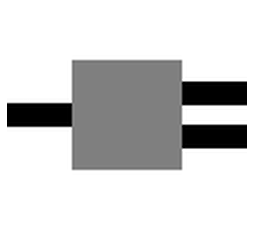

Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...


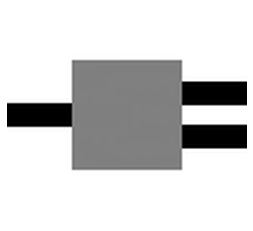

Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...


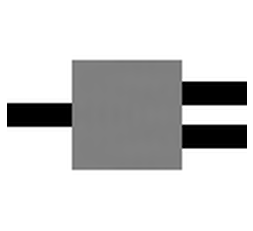

Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


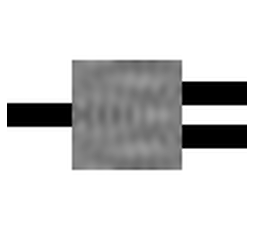

Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...


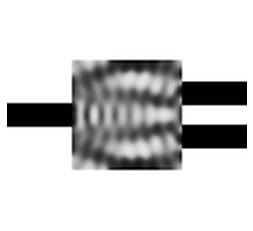

Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...


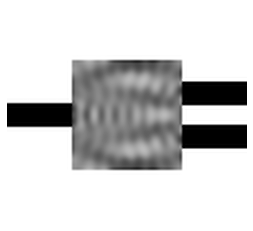

Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...


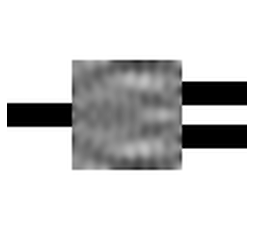

Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


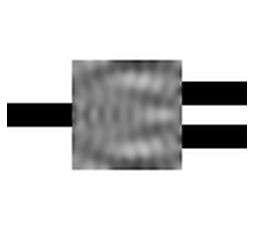

Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...


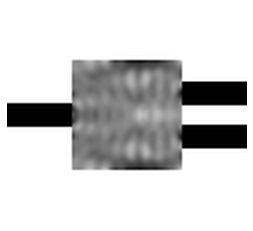

Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...


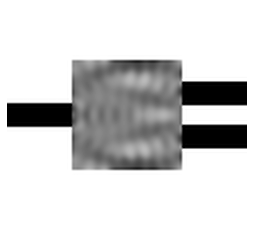

Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...


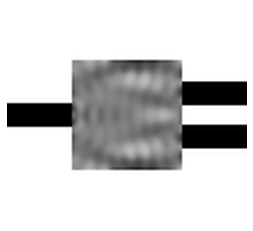

Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...


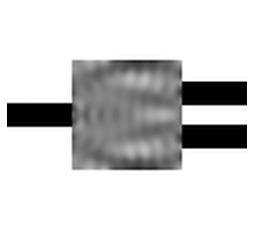

current beta:  8
Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...


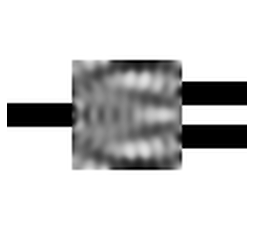

Current iteration: 14
Starting forward run...
Starting adjoint run...
Calculating gradient...


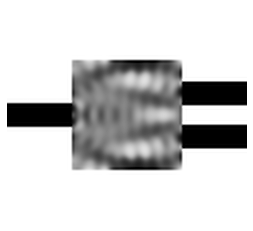

Current iteration: 15
Starting forward run...
Starting adjoint run...
Calculating gradient...


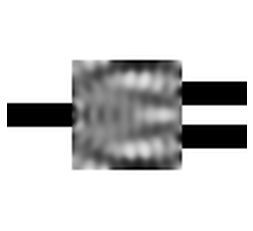

Current iteration: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


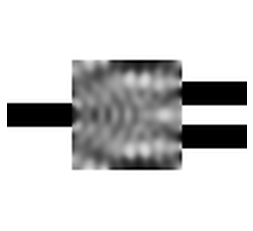

Current iteration: 17
Starting forward run...
Starting adjoint run...
Calculating gradient...


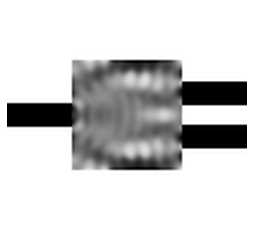

Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...


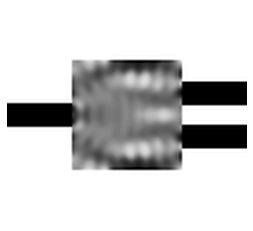

Current iteration: 19
Starting forward run...
Starting adjoint run...
Calculating gradient...


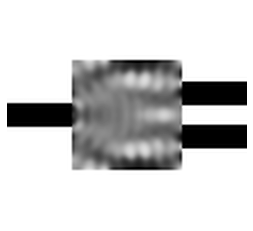

Current iteration: 20
Starting forward run...
Starting adjoint run...
Calculating gradient...


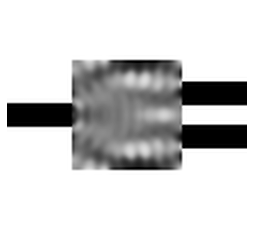

Current iteration: 21
Starting forward run...
Starting adjoint run...
Calculating gradient...


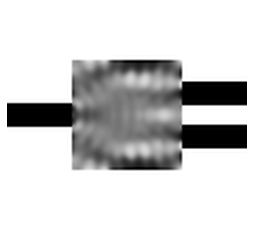

Current iteration: 22
Starting forward run...
Starting adjoint run...
Calculating gradient...


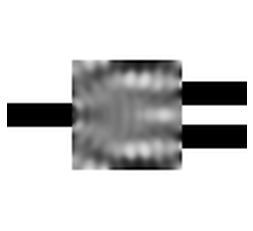

Current iteration: 23
Starting forward run...
Starting adjoint run...
Calculating gradient...


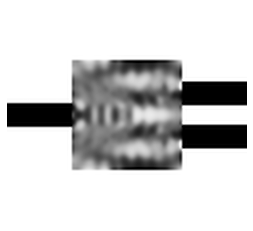

Current iteration: 24
Starting forward run...
Starting adjoint run...
Calculating gradient...


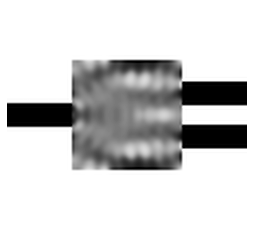

current beta:  16
Current iteration: 25
Starting forward run...
Starting adjoint run...
Calculating gradient...


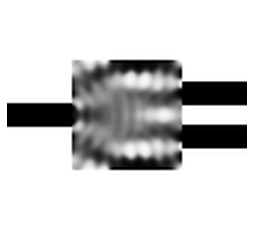

Current iteration: 26
Starting forward run...
Starting adjoint run...
Calculating gradient...


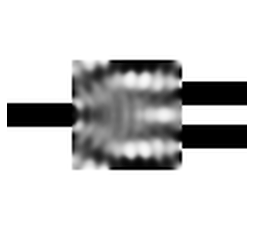

Current iteration: 27
Starting forward run...
Starting adjoint run...
Calculating gradient...


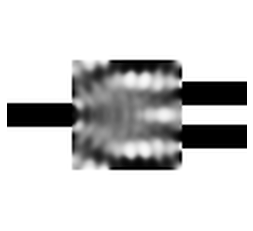

Current iteration: 28
Starting forward run...
Starting adjoint run...
Calculating gradient...


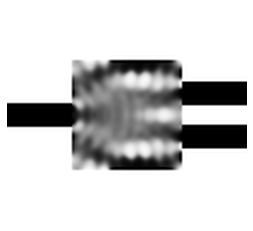

Current iteration: 29
Starting forward run...
Starting adjoint run...
Calculating gradient...


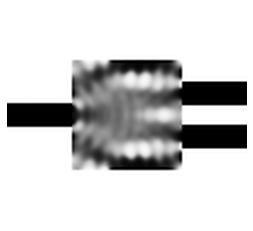

Current iteration: 30
Starting forward run...
Starting adjoint run...
Calculating gradient...


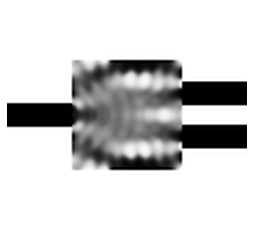

Current iteration: 31
Starting forward run...
Starting adjoint run...
Calculating gradient...


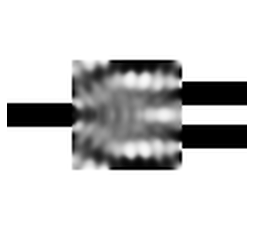

Current iteration: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


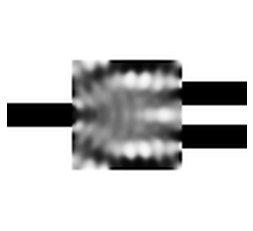

Current iteration: 33
Starting forward run...
Starting adjoint run...
Calculating gradient...


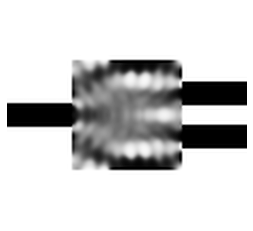

Current iteration: 34
Starting forward run...
Starting adjoint run...
Calculating gradient...


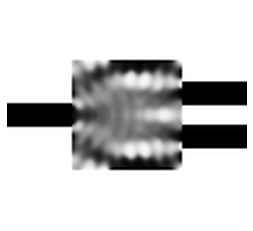

Current iteration: 35
Starting forward run...
Starting adjoint run...
Calculating gradient...


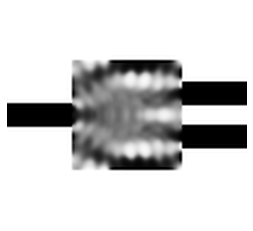

Current iteration: 36
Starting forward run...
Starting adjoint run...
Calculating gradient...


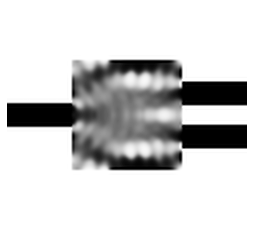

current beta:  32
Current iteration: 37
Starting forward run...
Starting adjoint run...
Calculating gradient...


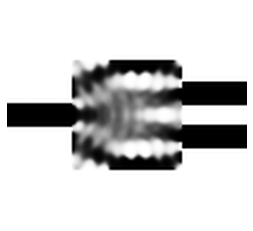

Current iteration: 38
Starting forward run...
Starting adjoint run...
Calculating gradient...


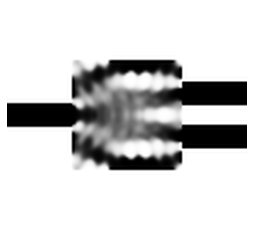

Current iteration: 39
Starting forward run...
Starting adjoint run...
Calculating gradient...


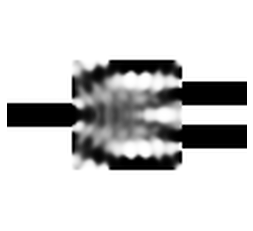

Current iteration: 40
Starting forward run...
Starting adjoint run...
Calculating gradient...


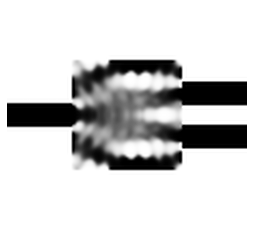

Current iteration: 41
Starting forward run...
Starting adjoint run...
Calculating gradient...


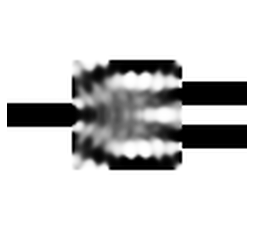

Current iteration: 42
Starting forward run...
Starting adjoint run...
Calculating gradient...


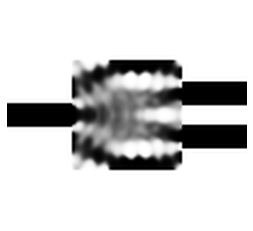

Current iteration: 43
Starting forward run...
Starting adjoint run...
Calculating gradient...


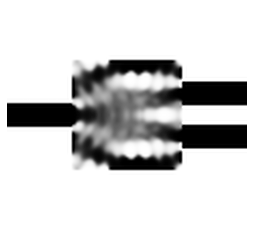

Current iteration: 44
Starting forward run...
Starting adjoint run...
Calculating gradient...


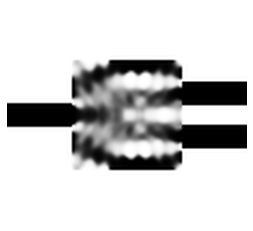

Current iteration: 45
Starting forward run...
Starting adjoint run...
Calculating gradient...


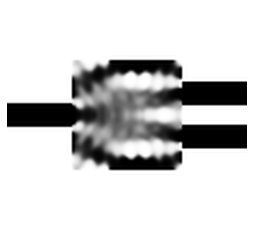

Current iteration: 46
Starting forward run...
Starting adjoint run...
Calculating gradient...


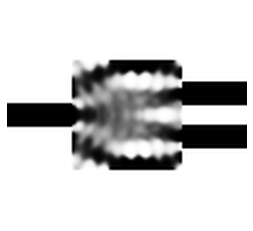

Current iteration: 47
Starting forward run...
Starting adjoint run...
Calculating gradient...


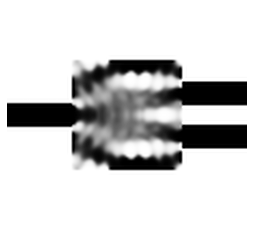

Current iteration: 48
Starting forward run...
Starting adjoint run...
Calculating gradient...


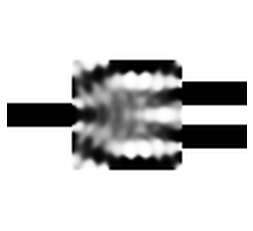

current beta:  64
Current iteration: 49
Starting forward run...
Starting adjoint run...
Calculating gradient...


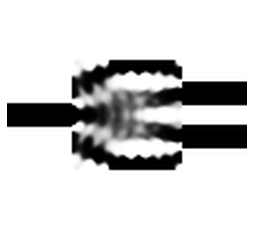

Current iteration: 50
Starting forward run...
Starting adjoint run...
Calculating gradient...


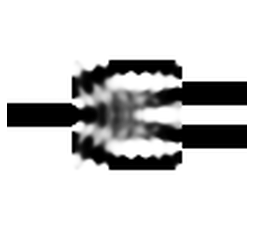

Current iteration: 51
Starting forward run...
Starting adjoint run...
Calculating gradient...


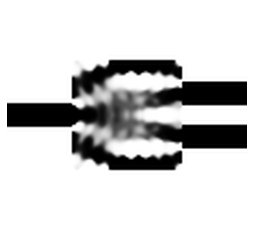

Current iteration: 52
Starting forward run...
Starting adjoint run...
Calculating gradient...


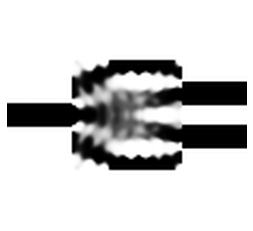

Current iteration: 53
Starting forward run...
Starting adjoint run...
Calculating gradient...


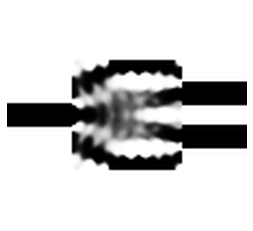

Current iteration: 54
Starting forward run...
Starting adjoint run...
Calculating gradient...


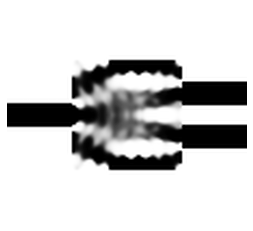

Current iteration: 55
Starting forward run...
Starting adjoint run...
Calculating gradient...


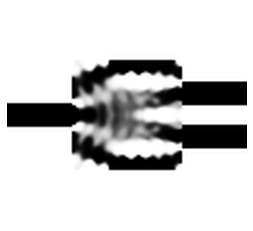

Current iteration: 56
Starting forward run...
Starting adjoint run...
Calculating gradient...


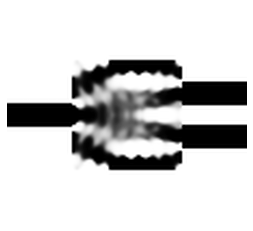

Current iteration: 57
Starting forward run...
Starting adjoint run...
Calculating gradient...


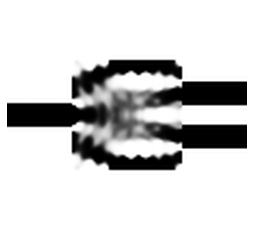

Current iteration: 58
Starting forward run...
Starting adjoint run...
Calculating gradient...


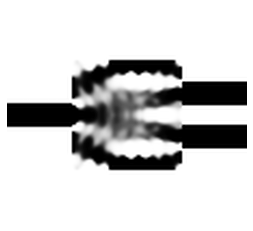

Current iteration: 59
Starting forward run...
Starting adjoint run...
Calculating gradient...


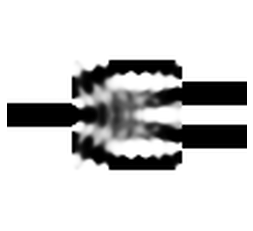

Current iteration: 60
Starting forward run...
Starting adjoint run...
Calculating gradient...


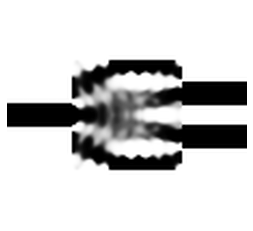

current beta:  128
Current iteration: 61
Starting forward run...
Starting adjoint run...
Calculating gradient...


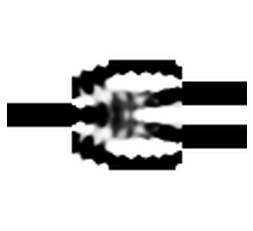

Current iteration: 62
Starting forward run...
Starting adjoint run...
Calculating gradient...


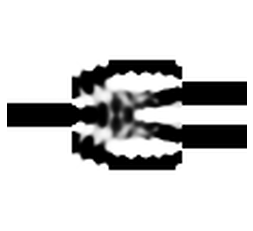

Current iteration: 63
Starting forward run...
Starting adjoint run...
Calculating gradient...


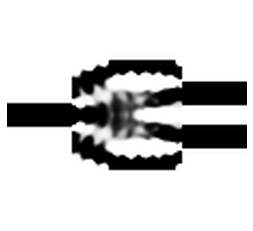

Current iteration: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


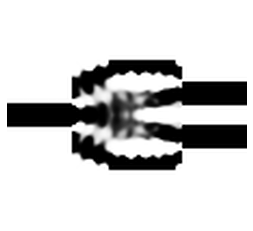

Current iteration: 65
Starting forward run...
Starting adjoint run...
Calculating gradient...


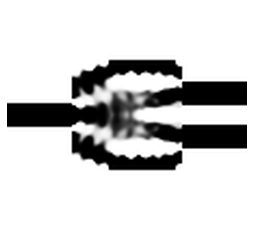

Current iteration: 66
Starting forward run...
Starting adjoint run...
Calculating gradient...


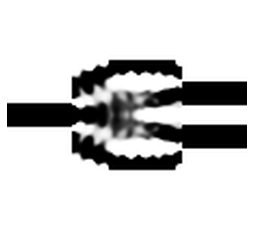

Current iteration: 67
Starting forward run...
Starting adjoint run...
Calculating gradient...


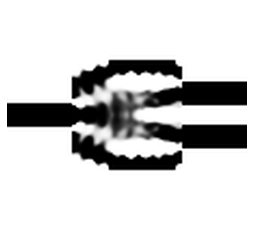

Current iteration: 68
Starting forward run...
Starting adjoint run...
Calculating gradient...


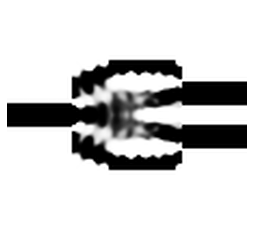

Current iteration: 69
Starting forward run...
Starting adjoint run...
Calculating gradient...


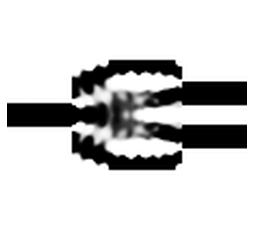

Current iteration: 70
Starting forward run...
Starting adjoint run...
Calculating gradient...


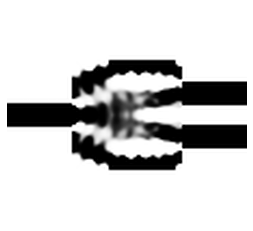

Current iteration: 71
Starting forward run...
Starting adjoint run...
Calculating gradient...


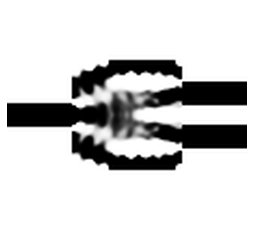

Current iteration: 72
Starting forward run...
Starting adjoint run...
Calculating gradient...


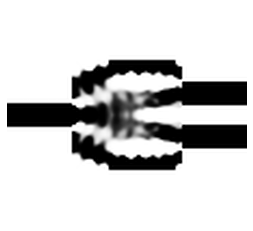

In [93]:
algorithm = nlopt.LD_MMA
n = Nx * Ny # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = 0
ub = 1

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 12
for iters in range(num_betas):
    print("current beta: ",cur_beta)
    
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a,g: f(a,g,cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta*beta_scale

## Final device evaluation

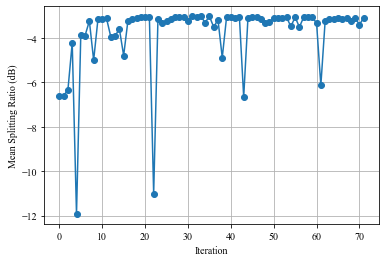

In [94]:
plt.figure()
plt.plot(10*np.log10(0.5*np.array(evaluation_history)),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Mean Splitting Ratio (dB)')
plt.show()

In [95]:
f0, dJ_du = opt([mapping(x,eta_i,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2

Starting forward run...


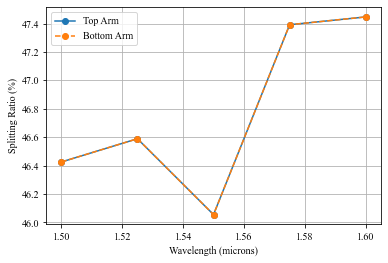

In [96]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'--o',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()